# **Notebook resources**

In [79]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install geopandas
!pip install category_encoders
!pip install catboost
!pip install xgboost
!pip install shap

In [81]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, RepeatedKFold
import shap

In [82]:
# SET CUSTOM MODULES FOLDER
import sys
sys.path.append('/content/drive/MyDrive/Kschool_TFM/src/modules/')

# CUSTOM MODULES
import model_funcs as mf
import viz_funcs as vf
import other_funcs as of

import os

In [83]:
datasets_folder = '/content/drive/MyDrive/Kschool_TFM/datasets'

In [84]:
df_clean = pd.read_csv(f'{datasets_folder}{os.sep}dataset-04-fe_clean.csv')
df_one_hot_encoding = pd.read_csv(f'{datasets_folder}{os.sep}dataset-05-modeling_one_hot_encoding.csv')

# **Hyperparameter tuning**

## **Train Test Split**

At this point we are going to separate the data into the corresponding training and test datasets.

In [85]:
model_evaluations_df = pd.DataFrame()
df_model = df_one_hot_encoding

In [ ]:
df_model.columns

Index(['price', 'size', 'hasParking', 'roomNumber', 'bathNumber',
       'hasSwimmingPool', 'hasTerrace', 'hasGarden', 'hasLift', 'hasAirco',
       'isNewDevelopment', 'price_m2_ft', 'atico', 'chalet', 'duplex',
       'estudio', 'loft', 'piso', 'Arganzuela', 'Barajas',
       'Barrio de Salamanca', 'Carabanchel', 'Centro', 'Chamartin', 'Chamberí',
       'Ciudad Lineal', 'Fuencarral', 'Hortaleza', 'Latina', 'Moncloa',
       'Moratalaz', 'Puente de Vallecas', 'Retiro', 'San Blas', 'Tetuán',
       'Usera', 'Vicálvaro', 'Villa de Vallecas', 'Villaverde', 'cluster'],
      dtype='object')

In [ ]:
#df_model = df_model.drop(['price_m2_ft'],axis=1)

In [ ]:
X = df_model.drop(['price'],axis=1)
y = df_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 42)

In [ ]:
print(X_train.shape,y_train.shape)

(17662, 39) (17662,)


In [ ]:
print(X_test.shape,y_test.shape)

(4416, 39) (4416,)


## **CatBoost Regressor**

#### **Cross Validation**

🕔 ***Be careful with the execution of the cell, it will take approximately 1 hour.***

In [ ]:
# https://catboost.ai/en/docs/en/references/training-parameters/common
%%time
CB_model = CatBoostRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=42) 
parameters = {'iterations': [1000,1200],
              'learning_rate': [0.04,0.05],
              'depth': [7,12],
              'l2_leaf_reg': [2,3],
              'loss_function': ['RMSE'],
              'random_strength': [5,8]}

grid_CB = mf.search_cv(X_train, y_train, CB_model, parameters, cv)

GridSearchCV
Fitting 6 folds for each of 32 candidates, totalling 192 fits
0:	learn: 249070.0062635	total: 3.67ms	remaining: 4.4s
1:	learn: 242236.3650651	total: 7.57ms	remaining: 4.53s
2:	learn: 235657.3327059	total: 10.4ms	remaining: 4.14s
3:	learn: 229349.3132134	total: 13.3ms	remaining: 3.98s
4:	learn: 223353.7570984	total: 16.2ms	remaining: 3.87s
5:	learn: 217161.7595978	total: 19.1ms	remaining: 3.8s
6:	learn: 211573.8487052	total: 22.1ms	remaining: 3.77s
7:	learn: 206257.1756790	total: 25.1ms	remaining: 3.74s
8:	learn: 201483.8310197	total: 28.1ms	remaining: 3.72s
9:	learn: 196234.1335692	total: 31.1ms	remaining: 3.7s
10:	learn: 191581.4527449	total: 34ms	remaining: 3.67s
11:	learn: 187065.1376806	total: 37ms	remaining: 3.66s
12:	learn: 182749.5596722	total: 39.8ms	remaining: 3.64s
13:	learn: 178564.5185185	total: 42.2ms	remaining: 3.57s
14:	learn: 174969.5416509	total: 45.1ms	remaining: 3.56s
15:	learn: 171347.1710506	total: 48ms	remaining: 3.55s
16:	learn: 167442.4293383	total:

711


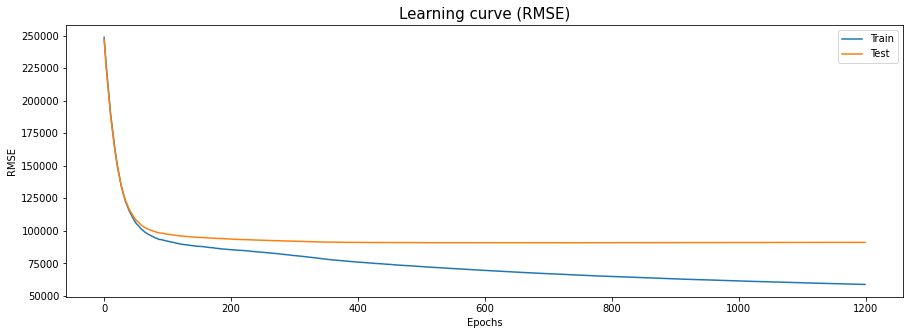

In [ ]:
CB_model = CatBoostRegressor(learning_rate = 0.04,
                             depth = 12,
                             loss_function = 'RMSE',
                             iterations = 1200,
                             l2_leaf_reg = 3,
                             verbose = False,
                             random_strength = 8)
CB_model.fit(X_train,
             y_train,
             eval_set = [(X_train, y_train),(X_test, y_test)],
             use_best_model = True,
             verbose = False
             )

CB_results = CB_model.get_evals_result()
CB_best_iteration = CB_model.get_best_iteration()
CB_feature_importance = CB_model.get_feature_importance
print(CB_best_iteration)
mf.plot_learning(CB_results,'RMSE')

In [ ]:
CB_ytrain = CB_model.predict(X_train)
CB_yhat = CB_model.predict(X_test)

model_evaluations_df = pd.concat([model_evaluations_df,mf.model_evaluation(y_train,CB_ytrain, 'CatBoost Regression (all data)','train')]).reset_index(drop=True)
model_evaluations_df = pd.concat([model_evaluations_df,mf.model_evaluation(y_test,CB_yhat, 'CatBoost Regression (all data)','test')]).reset_index(drop=True)
model_evaluations_df

,model,r2,mse,rmse,mae,type
0,CatBoost Regression (all data),0.9319,4.467556e+09,66839.7769,44108.6369,train
1,CatBoost Regression (all data),0.8726,8.243561e+09,90794.0571,58984.4397,test


In [ ]:
mf.cross_validate_models(X,y,CB_model)

{'fit_time': array([71.26659274, 69.88762403, 70.71212745, 70.9303    , 34.35890746]), 'score_time': array([0.08660245, 0.06055927, 0.05592847, 0.05626965, 0.02507138]), 'test_r2': array([0.8715203 , 0.87162681, 0.87280274, 0.87614565, 0.8813779 ]), 'test_neg_mean_squared_error': array([-8.31566004e+09, -8.78478820e+09, -8.38346276e+09, -8.02854037e+09,
       -7.47949358e+09]), 'test_neg_mean_absolute_error': array([-58942.94478616, -59242.2461897 , -58495.53927632, -57868.49544673,
       -55653.32800016])}


,model,r2,mse,rmse,mae
0,<catboost.core.CatBoostRegressor object at 0x7...,0.8747,8.198389e+09,90544.955633,58040.5107


#### **Model evaluation**

How does the RMSE act according to prices?

In [ ]:
CB_yhat = CB_model.predict(X_test)

check = pd.DataFrame(y_test)
check['yhat'] = CB_yhat
check

,price,yhat
17548,340000.0,269954.921220
12396,122898.0,104305.961174
3142,200000.0,253482.033786
4528,165000.0,149888.844826
17452,189990.0,172006.608097
...,...,...
17227,158000.0,130938.501121
20584,369900.0,351542.398520
1277,585000.0,639371.806545
21393,179900.0,164878.608389


In [ ]:
check_10 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9]).T['10%'][0]]
check_25 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9]).T['25%'][0]]
check_50 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9]).T['50%'][0]]
check_75 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9]).T['75%'][0]]
check_90 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9]).T['90%'][0]]
check_95 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9,0.95]).T['95%'][0]]

d_rmse = {
          '<= 10%' : np.sqrt(metrics.mean_squared_error(check_10['price'],check_10['yhat'])),
          '<= 25%' : np.sqrt(metrics.mean_squared_error(check_25['price'],check_25['yhat'])),
          '<= 50%' : np.sqrt(metrics.mean_squared_error(check_50['price'],check_50['yhat'])),
          '<= 75%' : np.sqrt(metrics.mean_squared_error(check_75['price'],check_75['yhat'])),
          '<= 90%' : np.sqrt(metrics.mean_squared_error(check_90['price'],check_90['yhat'])),
          '<= 95%' : np.sqrt(metrics.mean_squared_error(check_95['price'],check_95['yhat'])),
          '100%' : np.sqrt(metrics.mean_squared_error(check['price'],check['yhat']))
         }

df_rmse = pd.DataFrame([d_rmse])
df_rmse = df_rmse.T.reset_index().rename(columns={'index' : 'prices', 0 : 'rmse'})
display(df_rmse)

,prices,rmse
0,<= 10%,32637.351516
1,<= 25%,33009.005065
2,<= 50%,41276.383675
3,<= 75%,63486.804867
4,<= 90%,78471.558159
5,<= 95%,82332.420882
6,100%,90794.057110


We can see, if we check the RMSE according to percentiles of y_test that, when we have higher values, the error increases. This is something we corroborated during the project and one of the reasons why it was decided to limit the house prices.

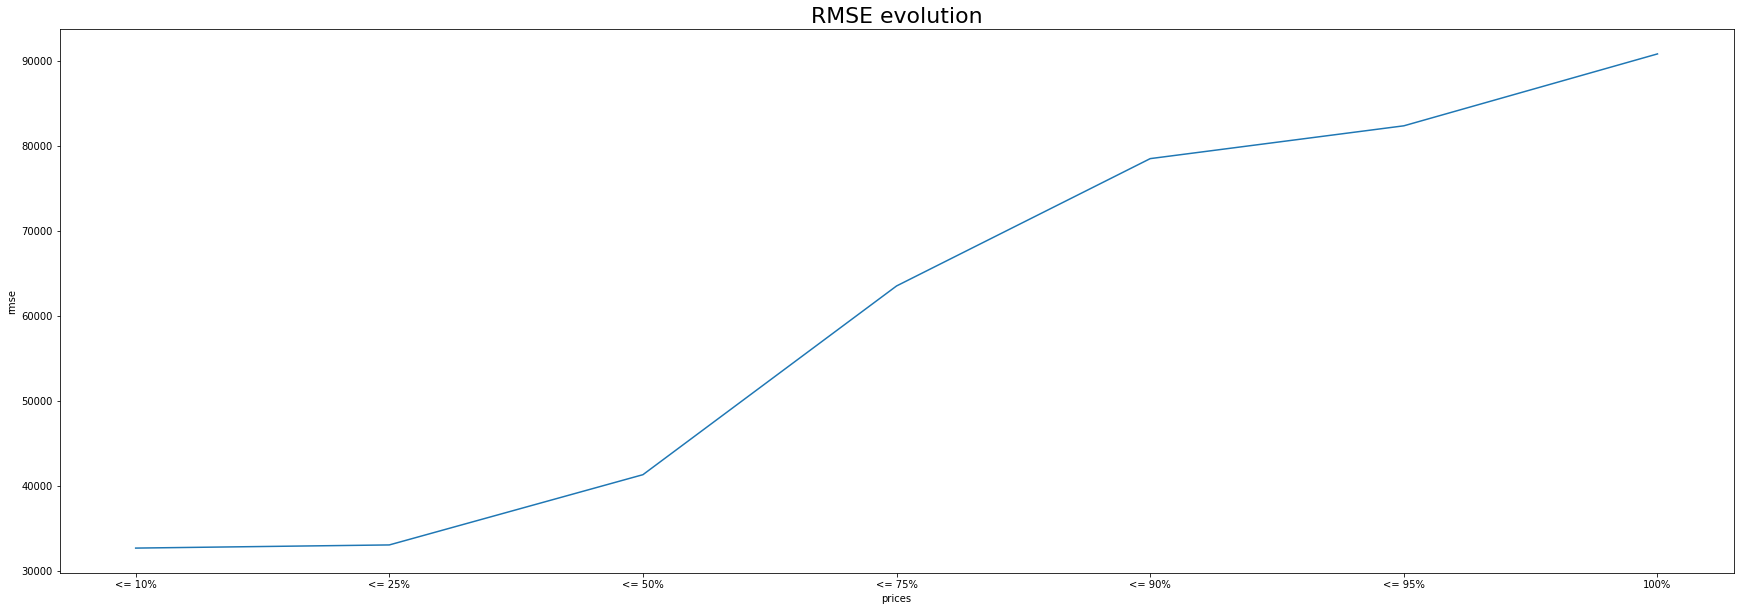

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (30,10))
ax.set_title('RMSE evolution', fontsize = 22)
sns.lineplot(data = df_rmse, x = 'prices', y='rmse');

With this small function we can predict with the model different lines of X_test in a random way to see the differences.

In [ ]:
mf.test_model_predictions(X_test,df_model,CB_model)

,index,real_price,predicted_price,difference
0,913,199875.0,109954.598218,89920.401782


The following graph represents the differences between actual and predicted prices, so that we can see where the distributions lie for each property type.

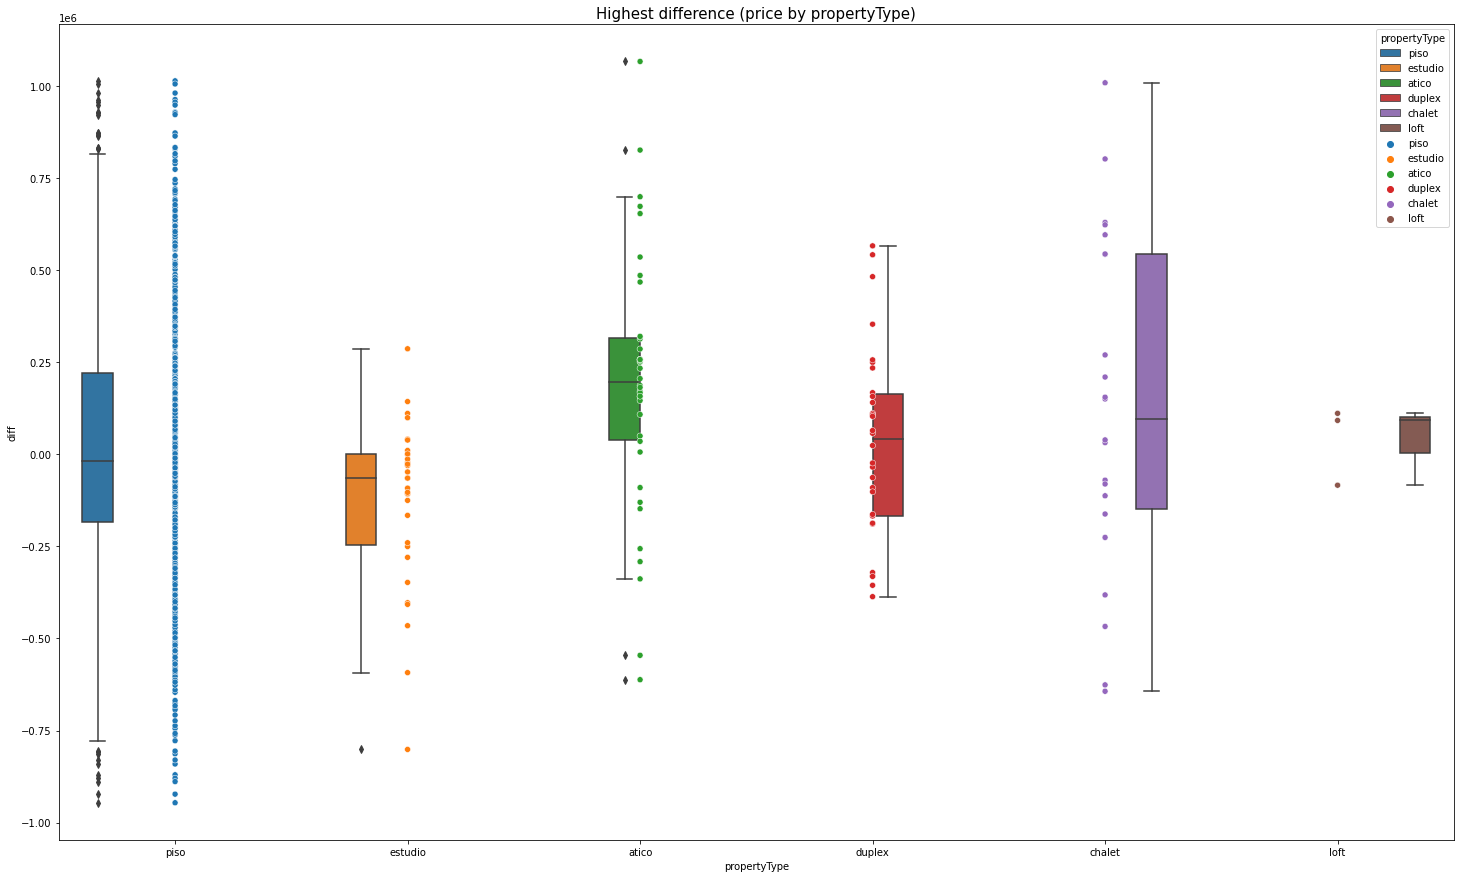

In [ ]:
mf.compare_prediction(df_clean, X_test, CB_yhat, 'propertyType')

In the following graph we can see how the absolute error starts to rise rapidly the higher the real house price is.

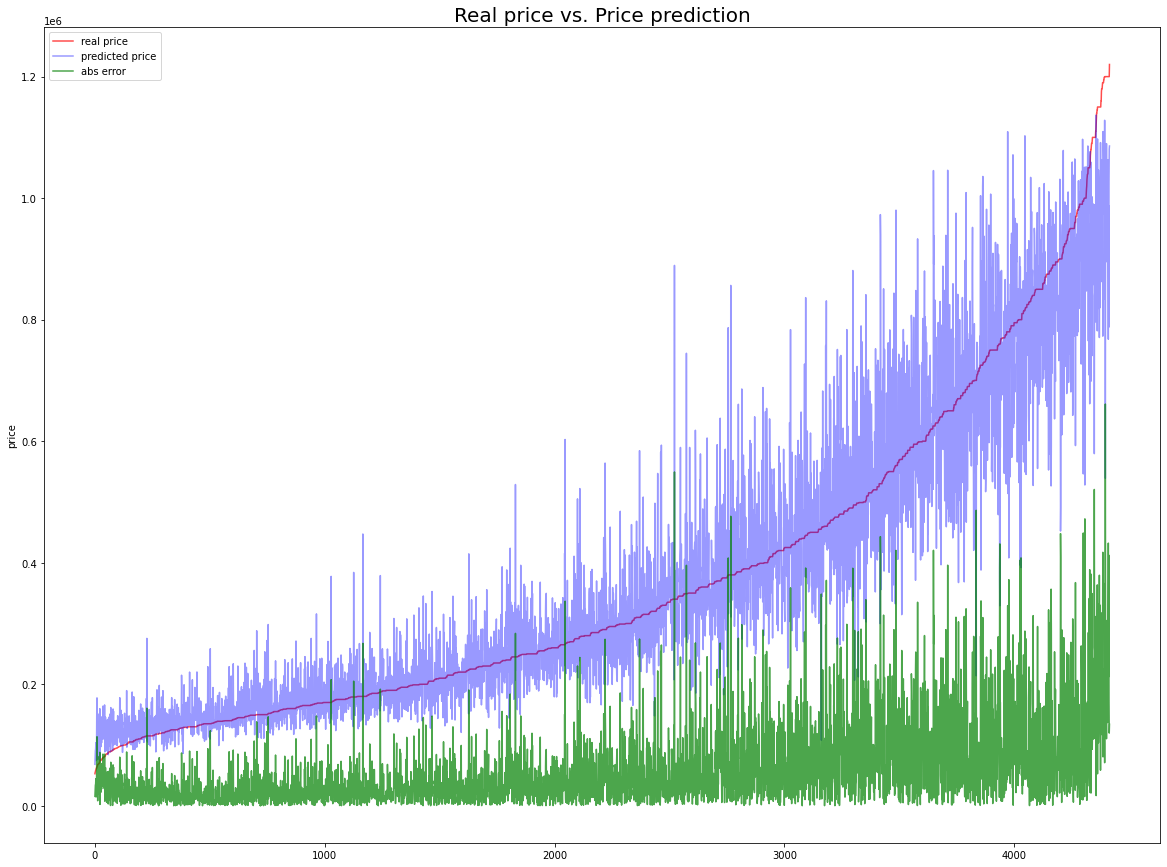

In [ ]:
mf.plot_error(y_test,CB_yhat)

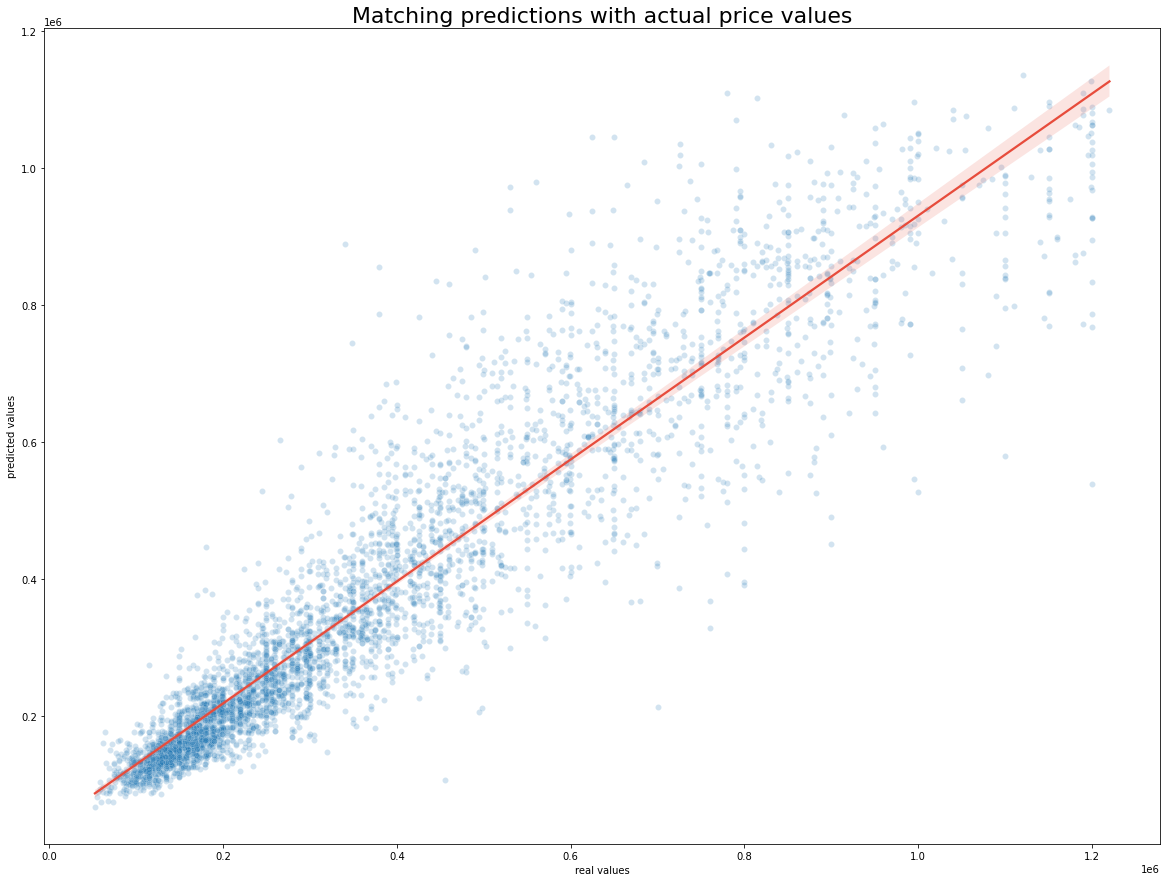

In [ ]:
mf.plot_matching(y_test,CB_yhat)

The Beeswarm SHAP plot allows us to see how each feature has influenced the prediction of the model.

In the following case, we can see how high values of features such as price_m2_ft, size and bathnumber influence the prediction by increasing the prediction.

🕔 ***Be careful with the execution of the cell, it will take approximately 30 minutes.***

In [ ]:
explainer = shap.Explainer(CB_model)
shap_values = explainer(X_test)
shap_array = explainer.shap_values(X_test)

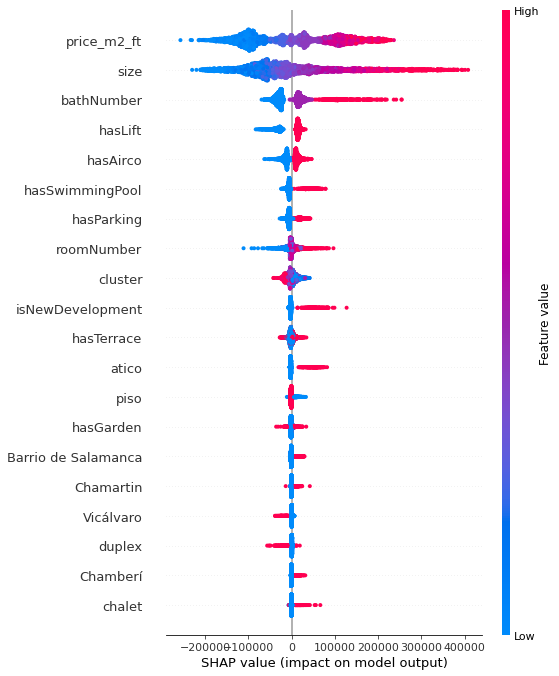

In [ ]:
shap.summary_plot(shap_values)

In the SHAP decision plot we can see how the features influence, once again, some of the predictions. It can be clearly seen how the first 3 features are very relevant in the prediction, being able to deviate it completely.

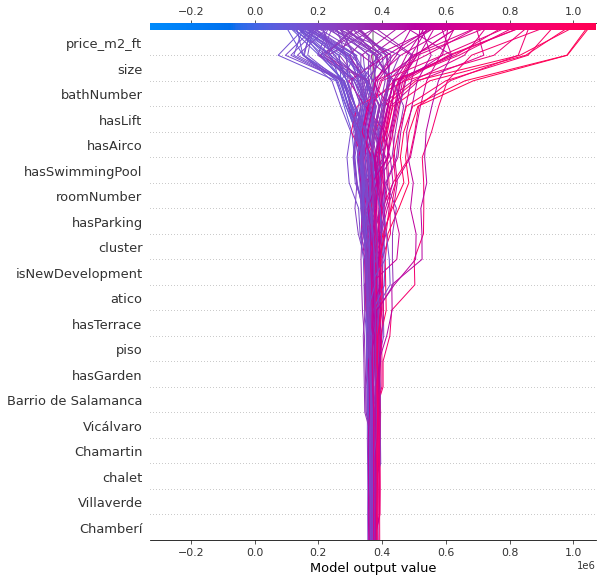

In [ ]:
shap.decision_plot(explainer.expected_value, shap_array[0:100],feature_names=list(X_train.columns))

It is similar to the decision plot, but we see more clearly how the features influence it.

In [ ]:
shap.initjs()
print(f'The expected value is {explainer.expected_value.round(2)} €')
shap.force_plot(explainer.expected_value, shap_array[11,:], X.iloc[1,:])

The expected value is 370844.55 €


Finally, we observe the importance of the features, ordered from highest to lowest, in the final prediction.

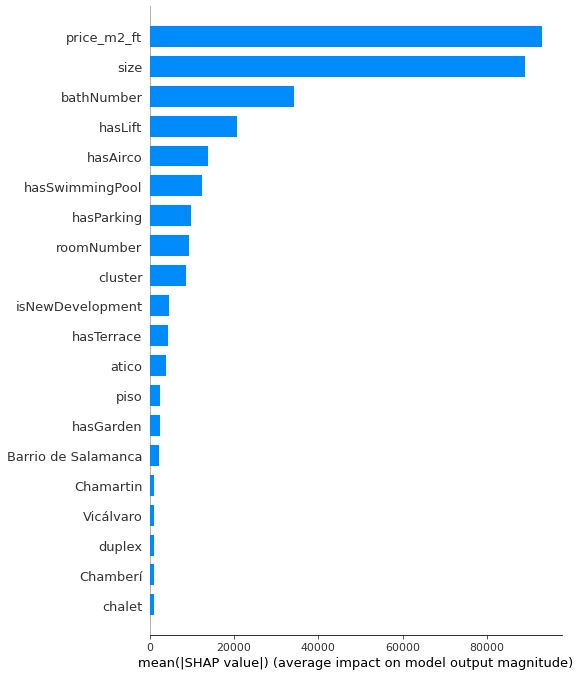

In [ ]:
shap.summary_plot(shap_array, X_test, plot_type='bar')

#### **Saving model**

In [ ]:
output_folder = '/content/drive/MyDrive/Kschool_TFM/output/'
CB_model.save_model(f"{output_folder}CatBoost.bin")

## **LGBM Regression**

#### **Cross Validation**

In [ ]:
%%time
LGBM_model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=42)
parameters = {'max_depth': [5,10],
              'learning_rate': [0.05,0.03],
              'n_estimators': [300,500,1000],
              'objective': ['regression']}

grid_LGBM = mf.search_cv(X_train, y_train, LGBM_model, parameters, cv)

GridSearchCV
Fitting 6 folds for each of 12 candidates, totalling 72 fits
{'best_score (RMSE)': 91900.6708, 'best_params': {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 500, 'objective': 'regression'}}
CPU times: user 3.9 s, sys: 189 ms, total: 4.09 s
Wall time: 37.2 s


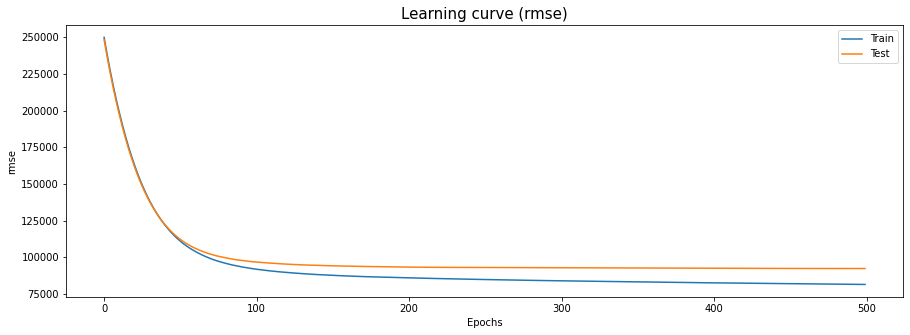

In [ ]:
LGBM_model = LGBMRegressor(max_depth = 10,
                           n_estimators = 500,
                           learning_rate = 0.03,
                           objective = 'regression'
                           )
LGBM_model.fit(X_train,
               y_train,
               eval_set = [(X_train, y_train),(X_test, y_test)],
               eval_metric = ['RMSE'],
               verbose = False
               )

LGBM_results = LGBM_model.evals_result_
LGBM_best_iteration = LGBM_model.best_iteration_
LGBM_feature_importance = LGBM_model.feature_importances_
mf.plot_learning(LGBM_results,'rmse')

In [ ]:
LGBM_ytrain = LGBM_model.predict(X_train)
LGBM_yhat = LGBM_model.predict(X_test)

model_evaluations_df = pd.concat([model_evaluations_df,mf.model_evaluation(y_train,LGBM_ytrain, 'LGBM Regression (all data)','train')]).reset_index(drop=True)
model_evaluations_df = pd.concat([model_evaluations_df,mf.model_evaluation(y_test,LGBM_yhat, 'LGBM Regression (all data)','test')]).reset_index(drop=True)
model_evaluations_df

,model,r2,mse,rmse,mae,type
0,LGBM Regression (all data),0.8988,6.636652e+09,81465.6465,53839.3361,train
1,LGBM Regression (all data),0.8683,8.524218e+09,92326.6893,60763.1975,test


In [ ]:
mf.cross_validate_models(X,y,LGBM_model)

{'fit_time': array([2.52489758, 2.5082643 , 1.96000886, 2.47402549, 1.44442463]), 'score_time': array([0.28698802, 0.28689766, 0.20881152, 0.20284295, 0.14885306]), 'test_r2': array([0.86829802, 0.87160853, 0.86929663, 0.87516979, 0.87957655]), 'test_neg_mean_squared_error': array([-8.52421756e+09, -8.78603952e+09, -8.61454724e+09, -8.09179778e+09,
       -7.59307447e+09]), 'test_neg_mean_absolute_error': array([-60763.19751228, -60812.4840749 , -59690.81507439, -59129.1986756 ,
       -57002.37399812])}


,model,r2,mse,rmse,mae
0,"LGBMRegressor(learning_rate=0.03, max_depth=10...",0.8728,8.321935e+09,91224.642026,59479.6139


#### **Model evaluation**

How does the RMSE act according to prices?

In [ ]:
LGBM_yhat = LGBM_model.predict(X_test)

check = pd.DataFrame(y_test)
check['yhat'] = LGBM_yhat
check

,price,yhat
17548,340000.0,273891.856734
12396,122898.0,102709.555959
3142,200000.0,262697.055904
4528,165000.0,143800.085110
17452,189990.0,167202.148163
...,...,...
17227,158000.0,127267.004939
20584,369900.0,352194.191480
1277,585000.0,689549.159942
21393,179900.0,160904.140426


In [ ]:
check_10 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9]).T['10%'][0]]
check_25 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9]).T['25%'][0]]
check_50 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9]).T['50%'][0]]
check_75 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9]).T['75%'][0]]
check_90 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9]).T['90%'][0]]
check_95 = check[check['price'] <= check.describe([0.1,0.25,0.5,0.75,0.9,0.95]).T['95%'][0]]

d_rmse = {
          '<= 10%' : np.sqrt(metrics.mean_squared_error(check_10['price'],check_10['yhat'])),
          '<= 25%' : np.sqrt(metrics.mean_squared_error(check_25['price'],check_25['yhat'])),
          '<= 50%' : np.sqrt(metrics.mean_squared_error(check_50['price'],check_50['yhat'])),
          '<= 75%' : np.sqrt(metrics.mean_squared_error(check_75['price'],check_75['yhat'])),
          '<= 90%' : np.sqrt(metrics.mean_squared_error(check_90['price'],check_90['yhat'])),
          '<= 95%' : np.sqrt(metrics.mean_squared_error(check_95['price'],check_95['yhat'])),
          '100%' : np.sqrt(metrics.mean_squared_error(check['price'],check['yhat']))
         }

df_rmse = pd.DataFrame([d_rmse])
df_rmse = df_rmse.T.reset_index().rename(columns={'index' : 'prices', 0 : 'rmse'})
display(df_rmse)

,prices,rmse
0,<= 10%,32569.915784
1,<= 25%,33861.367944
2,<= 50%,41776.076450
3,<= 75%,63972.625500
4,<= 90%,79552.348262
5,<= 95%,83313.282515
6,100%,92326.689338


We can see, if we check the RMSE according to percentiles of y_test that, when we have higher values, the error increases. The RMSE performance is exactly the same as with the CatBoost model, but with a larger error.

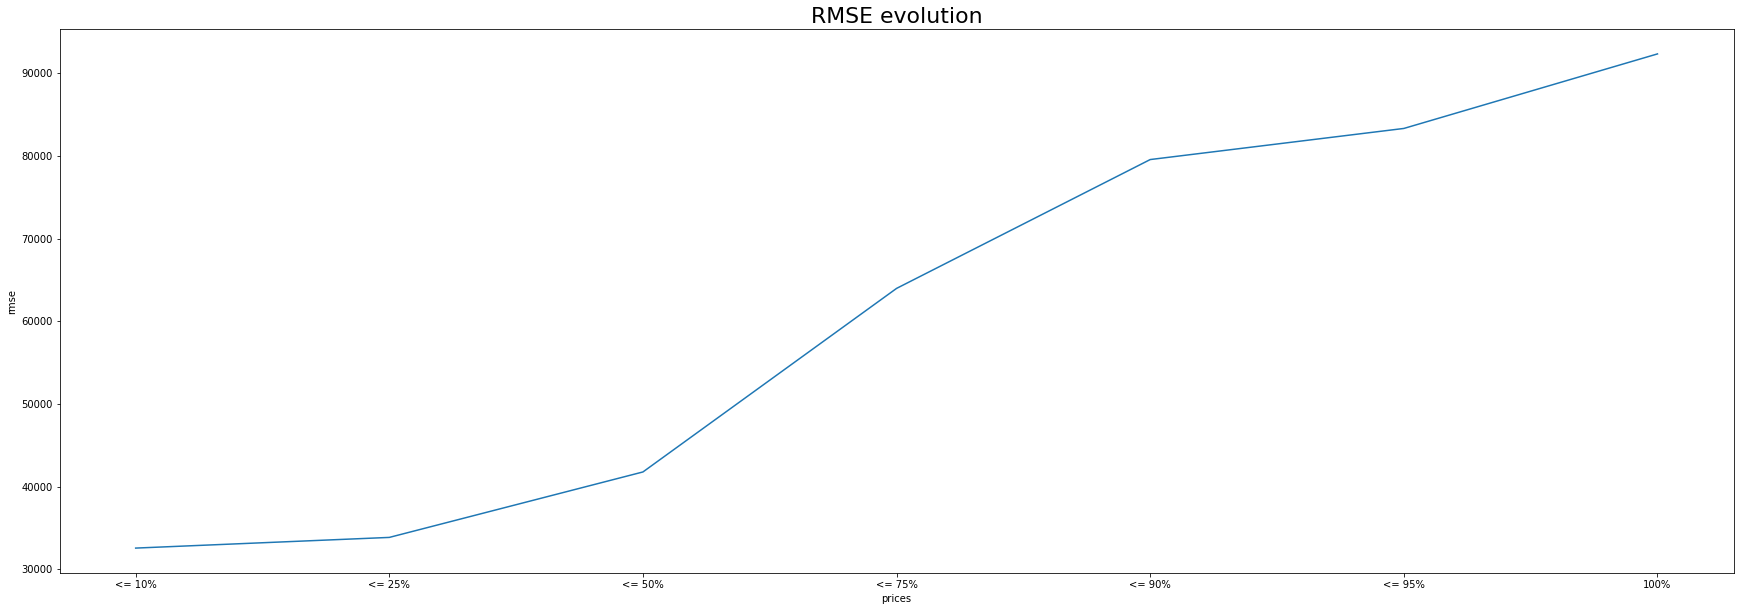

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (30,10))
ax.set_title('RMSE evolution', fontsize = 22)
sns.lineplot(data = df_rmse, x = 'prices', y='rmse');

With this small function we can predict with the model different lines of X_test in a random way to see the differences.

In [ ]:
mf.test_model_predictions(X_test,df_model,LGBM_model)

,index,real_price,predicted_price,difference
0,1177,149000.0,155721.938682,-6721.938682


The following graph represents the differences between actual and predicted prices, so that we can see where the distributions lie for each property type.

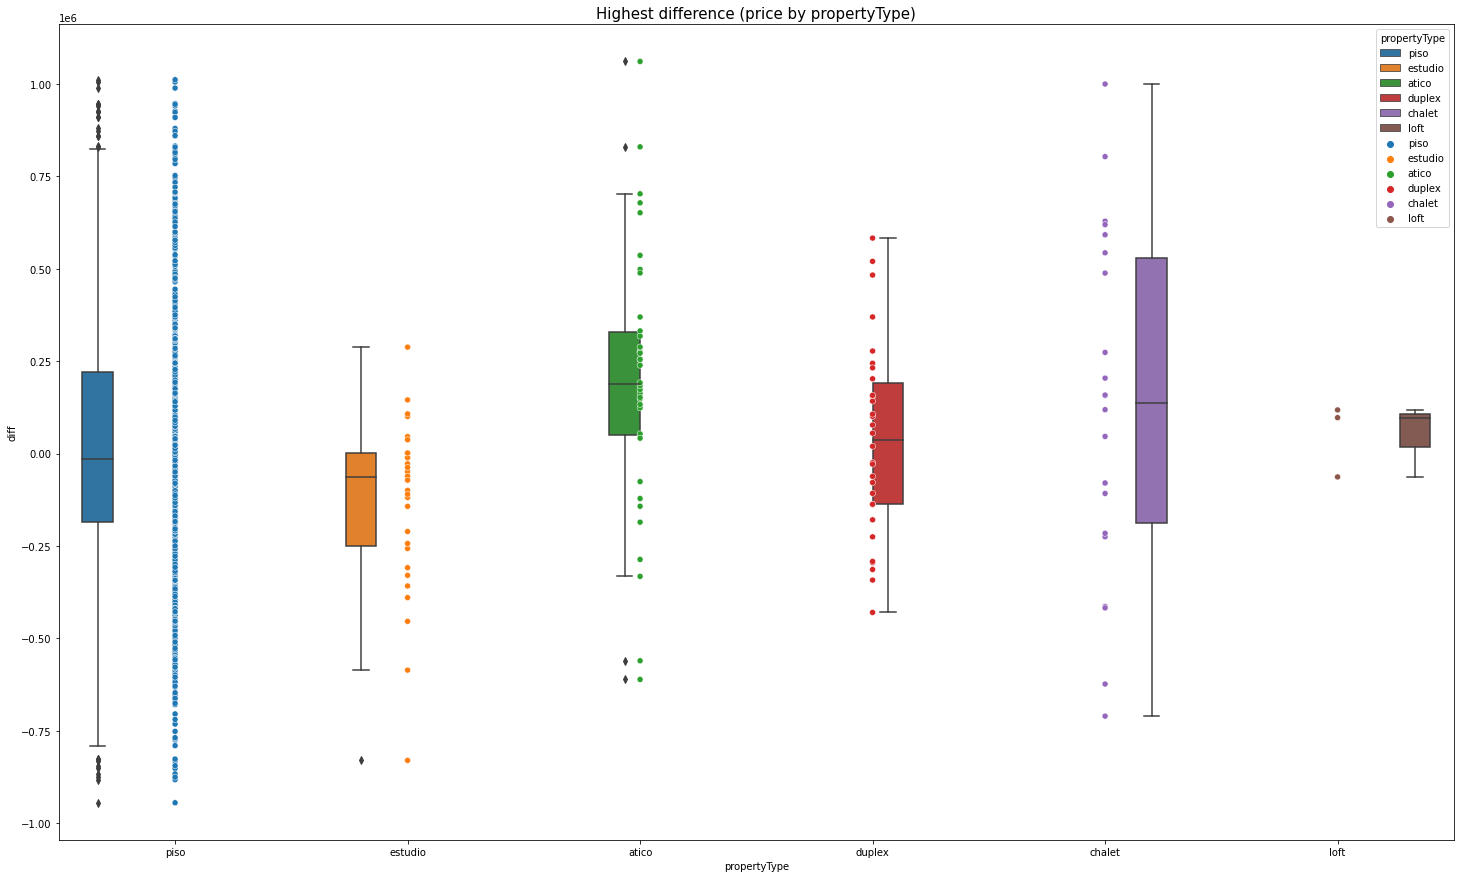

In [ ]:
mf.compare_prediction(df_clean, X_test, LGBM_yhat, 'propertyType')

In the following graph we can see how the absolute error starts to rise rapidly the higher the real house price is.

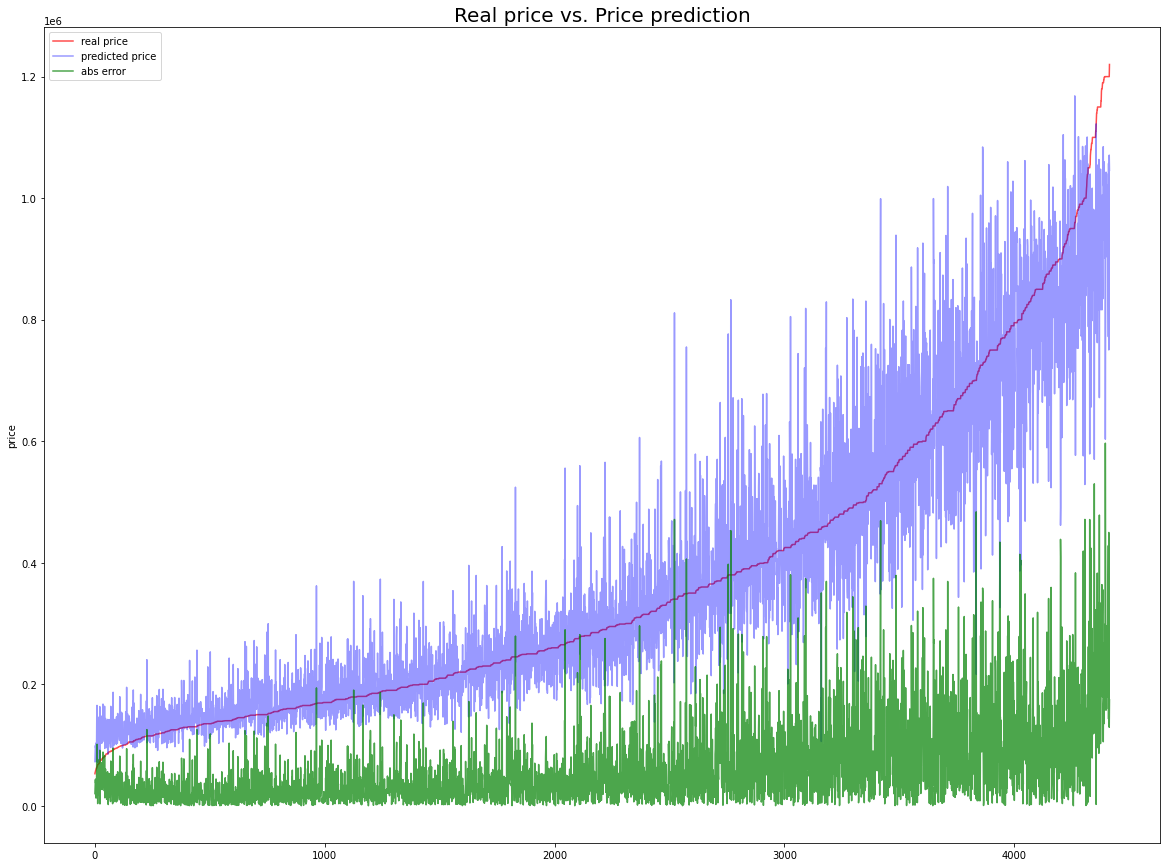

In [ ]:
mf.plot_error(y_test,LGBM_yhat)

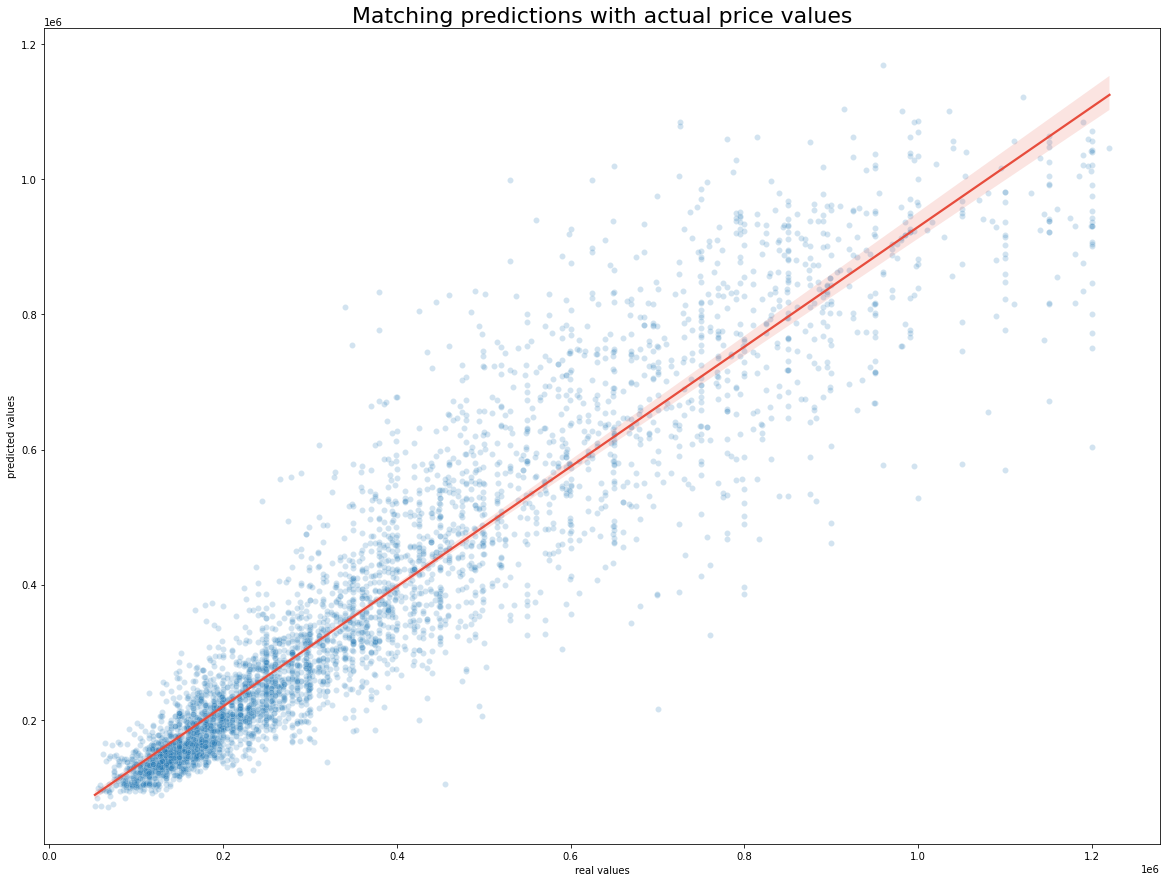

In [ ]:
mf.plot_matching(y_test,LGBM_yhat)

The Beeswarm SHAP plot allows us to see how each feature has influenced the prediction of the model.

In the following case, we can see how high values of features such as size, price_m2_ft and bathnumber influence the prediction by increasing the prediction.

In [ ]:
explainer = shap.Explainer(LGBM_model)
shap_values = explainer(X_test)
shap_array = explainer.shap_values(X_test)

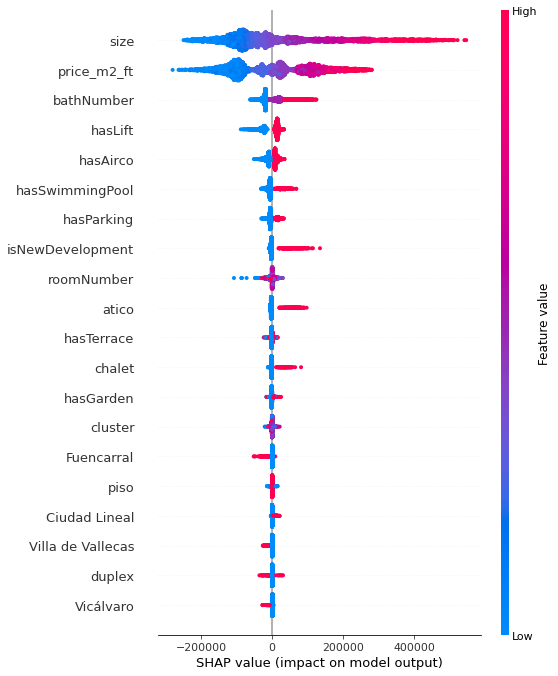

In [ ]:
shap.summary_plot(shap_values)

In the SHAP decision plot we can see how the features influence, once again, some of the predictions. It can be clearly seen how the first 3 features are very relevant in the prediction, being able to deviate it completely.

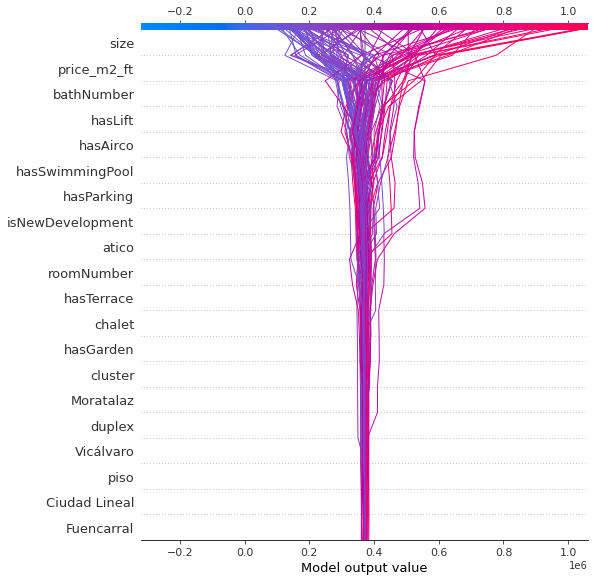

In [ ]:
shap.decision_plot(explainer.expected_value, shap_array[0:100],feature_names=list(X_train.columns))

It is similar to the decision plot, but we see more clearly how the features influence it.

In [ ]:
shap.initjs()
print(f'The expected value is {explainer.expected_value.round(2)} €')
shap.force_plot(explainer.expected_value, shap_array[11,:], X.iloc[1,:])

The expected value is 370858.07 €


Finally, we observe the importance of the features, ordered from highest to lowest, in the final prediction.

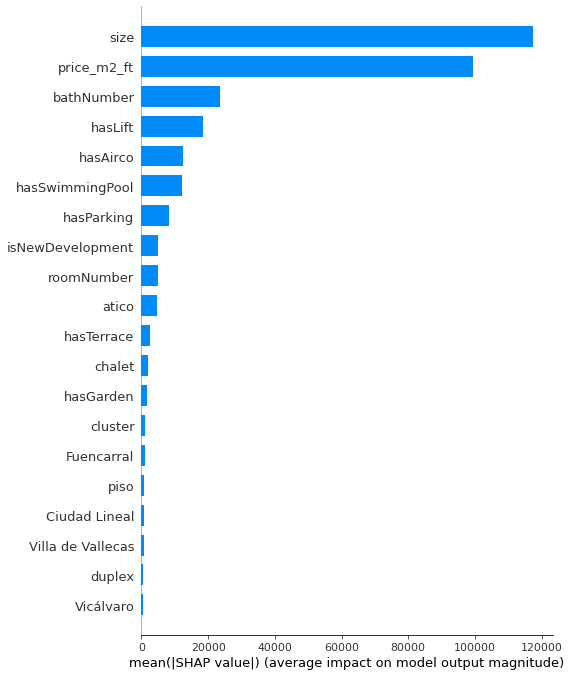

In [ ]:
shap.summary_plot(shap_array, X_test, plot_type='bar')

#### **Saving model**

In [ ]:
output_folder = '/content/drive/MyDrive/Kschool_TFM/output/'
LGBM_model.booster_.save_model(f"{output_folder}LGBM.bin")

# **Recommender system**

Finally, we have implemented a small recommender based on cosine similarity in order to be able to recommend to the user other properties that are similar to the features introduced in the frontend.

In [ ]:
recommender_df = df_one_hot_encoding.copy()

In [ ]:
recommender_df.head()

,price,size,hasParking,roomNumber,bathNumber,hasSwimmingPool,hasTerrace,hasGarden,hasLift,hasAirco,...,Moratalaz,Puente de Vallecas,Retiro,San Blas,Tetuán,Usera,Vicálvaro,Villa de Vallecas,Villaverde,cluster
0,995000.0,179.0,0.0,4.0,5.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7
1,315000.0,96.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,265000.0,64.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
3,136000.0,55.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
4,194400.0,197.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8


In [ ]:
def similarity(df, comparation):
  #district = float(comparation['district'])
  similarities = {}
  similarities = {i : float(cosine_similarity(comparation,df[df.index == i])[0]) for i,v in df.iterrows()}
  similarities = pd.DataFrame([similarities]).T.rename(columns={0: "cosine_similarity"})
  similarities = similarities.reset_index().sort_values(by='cosine_similarity', ascending=False).reset_index(drop=True)[:6]
  similarities = df[(df.index.isin(similarities['index'])) & (~df.index.isin(comparation.index))]

  return similarities

index = 9289 # cambiar el index para comparar diferentes propiedades
to_compare = recommender_df[recommender_df.index == index]
recommendation = similarity(recommender_df, to_compare)
display(to_compare)
display(recommendation)
display(df_clean[df_clean.index.isin(recommendation.index)])

,price,size,hasParking,roomNumber,bathNumber,hasSwimmingPool,hasTerrace,hasGarden,hasLift,hasAirco,...,Moratalaz,Puente de Vallecas,Retiro,San Blas,Tetuán,Usera,Vicálvaro,Villa de Vallecas,Villaverde,cluster
9289,590000.0,134.0,0.0,4.0,2.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14


,price,size,hasParking,roomNumber,bathNumber,hasSwimmingPool,hasTerrace,hasGarden,hasLift,hasAirco,...,Moratalaz,Puente de Vallecas,Retiro,San Blas,Tetuán,Usera,Vicálvaro,Villa de Vallecas,Villaverde,cluster
568,590000.0,130.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14
6974,590000.0,136.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14
14116,590000.0,132.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14
14981,590000.0,131.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14
15296,590000.0,133.0,1.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14


,propertyType,price,size,hasParking,roomNumber,bathNumber,hasSwimmingPool,hasTerrace,hasGarden,hasLift,hasAirco,isNewDevelopment,district,price_m2_ft
568,piso,590000.0,130.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,Retiro,5413.0
6974,piso,590000.0,136.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,Retiro,5413.0
14116,piso,590000.0,132.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,Retiro,5413.0
14981,piso,590000.0,131.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,Retiro,5413.0
15296,piso,590000.0,133.0,1.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,Retiro,5413.0
